In [370]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)
import plotly.express as px 


Populating the interactive namespace from numpy and matplotlib


In [371]:
%config Completer.use_jedi = False

In [372]:
import pathlib

In [373]:
import pandas as pd
import numpy as np

In [374]:
DATA_DIR = pathlib.Path("../data")

In [375]:
!ls ../data

AEP_hourly.csv	   EKPC_hourly.csv		  __MACOSX
COMED_hourly.csv   est_hourly.paruqet		  NI_hourly.csv
DAYTON_hourly.csv  FE_hourly.csv		  PJME_hourly.csv
DEOK_hourly.csv    hourly-energy-consumption.zip  pjm_hourly_est.csv
DOM_hourly.csv	   LD2011_2014.txt		  PJM_Load_hourly.csv
DUQ_hourly.csv	   LD2011_2014.txt.zip		  PJMW_hourly.csv


In [552]:
eldata = pd.read_csv(DATA_DIR/'LD2011_2014.txt', sep=';', decimal=',')
eldata.columns = ["timestamp"]+[f"MT_{i+1:0>3}" for i in range(370)]

In [553]:
eldata["timestamp"] = pd.to_datetime(eldata.timestamp)

In [554]:
eldata = eldata.resample("1H", on="timestamp").mean()

In [651]:
data = eldata

# Adding calendar features
data["yearly_cycle"] = np.sin(2 * np.pi * data.index.dayofyear / 366)
data["weekly_cycle"] = np.sin(2 * np.pi * data.index.dayofweek / 7)
data["daily_cycle"] = np.sin(2 * np.pi * data.index.hour / 24)
calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]
# calendar_features = ["daily_cycle"]

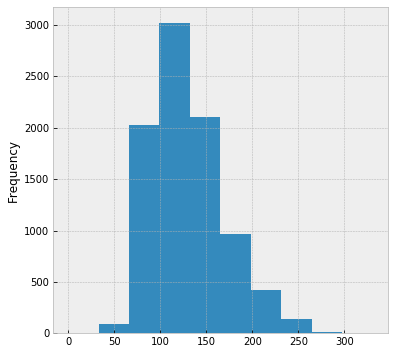

In [648]:
plt.figure(figsize=(6,6))
eldata['2013-01-01':'2014-01-01']['MT_046'].plot(kind="hist", ax=plt.gca())

In [557]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [666]:
class MQRNN_dataset(Dataset):
    """Sample data from electricity load dataset (per household, resampled to one hour)."""

    def __init__(self,
                series_df:pd.DataFrame,
                covariate_df:pd.DataFrame, 
                 
                horizon_size:int,
                quantile_size:int):
        
        self.series_df = series_df
        self.covariate_df = covariate_df
        self.horizon_size = horizon_size
        self.quantile_size = quantile_size
        
        full_covariate = []
        covariate_size = self.covariate_df.shape[1]
        print(f"self.covariate_df.shape[0] : {self.covariate_df.shape[0]}")
        for i in range(1, self.covariate_df.shape[0] - horizon_size+1):
            cur_covariate = []
            cur_covariate.append(self.covariate_df.iloc[i:i+horizon_size,:].to_numpy())
            full_covariate.append(cur_covariate)
        full_covariate = np.array(full_covariate)
        print(f"full_covariate shape: {full_covariate.shape}")
        full_covariate = full_covariate.reshape(-1, horizon_size * covariate_size)
        self.next_covariate = full_covariate
        
    def __len__(self):
        return self.series_df.shape[1]
    
    def __getitem__(self,idx):
        cur_series = np.array(self.series_df.iloc[: -self.horizon_size, idx])
        cur_covariate = np.array(self.covariate_df.iloc[:-self.horizon_size, :]) # covariate used in generating hidden states

        covariate_size = self.covariate_df.shape[1]

        real_vals_list = []
        for i in range(1, self.horizon_size+1):
            real_vals_list.append(np.array(self.series_df.iloc[i: self.series_df.shape[0]-self.horizon_size+i, idx]))
        real_vals_array = np.array(real_vals_list) #[horizon_size, seq_len]
        real_vals_array = real_vals_array.T #[seq_len, horizon_size]
        cur_series_tensor = torch.tensor(cur_series)
        
        cur_series_tensor = torch.unsqueeze(cur_series_tensor,dim=1) # [seq_len, 1]
        cur_covariate_tensor = torch.tensor(cur_covariate) #[seq_len, covariate_size]
        cur_series_covariate_tensor = torch.cat([cur_series_tensor, cur_covariate_tensor],dim=1)
        next_covariate_tensor = torch.tensor(self.next_covariate) #[seq_len, horizon_size * covariate_size]

        cur_real_vals_tensor = torch.tensor(real_vals_array)
        return cur_series_covariate_tensor, next_covariate_tensor, cur_real_vals_tensor

In [667]:
class Encoder(pl.LightningModule):
    """
    Encoder of the Encoder-Decoder Structure. For MQ_RNN, this encoder
    is the same as the traditional seq2seq model, which is based on the LSTM.
    """
    def __init__(self, 
                horizon_size:int, 
                covariate_size:int, 
                hidden_size:int, 
                dropout:float, 
                layer_size:int, 
                by_direction:bool,
                device):
        super().__init__()
        self.horizon_size = horizon_size
        self.covariate_size = covariate_size
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.by_direction = by_direction
        self.dropout = dropout
        self.LSTM = nn.LSTM(input_size= covariate_size+1, 
                            hidden_size=hidden_size, 
                            num_layers=layer_size, 
                            dropout=dropout,
                            bidirectional=by_direction)
        for param in self.LSTM.parameters():
            if len(param.shape) >= 2:
                torch.nn.init.orthogonal_(param.data)
            else:
                torch.nn.init.normal_(param.data)
    
    def forward(self, input):
        """
        For the RNN(LSTM), the input shape is [seq_len,batch_size,input_size]
        where input_size = covariate_size +1
        """
        seq_len = input.shape[0]
        batch_size = input.shape[1]
        input_size = input.shape[2]
        layer_size = self.layer_size
        direction_size = 1
        if self.by_direction:
            direction_size = 2
        outputs,_ = self.LSTM(input)
        outputs_reshape = outputs.view(seq_len,batch_size,direction_size,self.hidden_size)
        outputs_last_layer = outputs_reshape[:,:,-1,:]
        final_outputs = outputs_last_layer.view(seq_len,batch_size,self.hidden_size)
        return final_outputs

In [668]:
class GlobalDecoder(pl.LightningModule):
    """
    Based on the hidden tensor generated by the Encoder and the values
    of the covariate time series in prediction horizon
    input_size = hidden_size + covariate_size * horizon_size
    output_size: (horizon_size+1) * context_size
    """
    def __init__(self,
                 hidden_size:int, 
                 covariate_size:int,
                 horizon_size:int,
                 context_size:int):
        super().__init__()
        self.hidden_size = hidden_size
        self.covariate_size = covariate_size
        self.horizon_size = horizon_size
        self.context_size = context_size

        self.linear1 = nn.Linear(in_features= hidden_size + covariate_size*horizon_size, 
                                out_features= horizon_size*hidden_size*3)
        
        self.linear2 = nn.Linear(in_features= horizon_size*hidden_size*3, 
                                out_features= horizon_size*hidden_size*2)
        
        self.linear3 = nn.Linear(in_features= horizon_size*hidden_size*2, 
                                out_features= (horizon_size+1)*context_size)

        self.activation = nn.ReLU()
    def forward(self, input):
        layer1_output = self.linear1(input)
        layer1_output = self.activation(layer1_output)

        layer2_output = self.linear2(layer1_output)
        layer2_output = self.activation(layer2_output)

        layer3_output = self.linear3(layer2_output)
        layer3_output = self.activation(layer3_output)
        return layer3_output


class LocalDecoder(pl.LightningModule):
    """
    Based on the resulting tensor generated by the GlobalDecoder and the 
    covariate time series value at prediction step.
    input_size: (horizon_size+1)*context_size + horizon_size*covariate_size
    output_size: horizon_size * quantile_size
    """
    def __init__(self,
                covariate_size, 
                quantile_size,
                context_size,
                quantiles,
                horizon_size):
        super().__init__()
        self.covariate_size = covariate_size
        self.quantiles = quantiles
        self.quantile_size = quantile_size
        self.horizon_size = horizon_size
        self.context_size = context_size

        self.linear1 = nn.Linear(in_features= horizon_size*context_size + horizon_size* covariate_size + context_size,
                                 out_features= horizon_size* context_size)
        self.linear2 = nn.Linear(in_features= horizon_size* context_size,
                                 out_features= horizon_size* quantile_size)
        self.activation = nn.ReLU()
    
    def forward(self,input):
        layer1_output = self.linear1(input)
        layer1_output = self.activation(layer1_output)

        layer2_output = self.linear2(layer1_output)
        layer2_output = self.activation(layer2_output)
        return layer2_output

In [669]:
class MQRNN:
    """
    This class holds the encoder and the global decoder and local decoder.
    """
    def __init__(self, 
                horizon_size:int, 
                hidden_size:int, 
                quantiles:list,
                dropout:float,
                layer_size:int,
                by_direction:bool,
                lr:float,
                batch_size:int, 
                num_epochs:int, 
                context_size:int, 
                covariate_size:int,
                device):
        print(f"device is: {device}")
        self.device = device
        self.horizon_size = horizon_size
        self.quantile_size = len(quantiles)
        self.quantiles = quantiles
        self.lr = lr 
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.covariate_size = covariate_size
        quantile_size = self.quantile_size
        self.encoder = Encoder(horizon_size=horizon_size,
                               covariate_size=covariate_size,
                               hidden_size=hidden_size, 
                               dropout=dropout,
                               layer_size=layer_size,
                               by_direction=by_direction,
                               device=device)
        
        self.gdecoder = GlobalDecoder(hidden_size=hidden_size,
                                    covariate_size=covariate_size,
                                    horizon_size=horizon_size,
                                    context_size=context_size)
        self.ldecoder = LocalDecoder(covariate_size=covariate_size,
                                    quantile_size=quantile_size,
                                    context_size=context_size,
                                    quantiles=quantiles,
                                    horizon_size=horizon_size)
        self.encoder.double()
        self.gdecoder.double()
        self.ldecoder.double()
    
    def train(self, dataset:MQRNN_dataset):
        
        train_fn(encoder=self.encoder, 
                gdecoder=self.gdecoder, 
                ldecoder=self.ldecoder,
                dataset=dataset,
                lr=self.lr,
                batch_size=self.batch_size,
                num_epochs=self.num_epochs,
                device=self.device)
        print("training finished")
    
    def predict(self, train_target_df, train_covariate_df, test_covariate_df, col_name):

        input_target_tensor = torch.tensor(train_target_df[[col_name]].to_numpy())
        full_covariate = train_covariate_df.to_numpy()
        full_covariate_tensor = torch.tensor(full_covariate)

        next_covariate = test_covariate_df.to_numpy()
        next_covariate = next_covariate.reshape(-1, self.horizon_size * self.covariate_size)
        next_covariate_tensor = torch.tensor(next_covariate) #[1,horizon_size * covariate_size]
        print(f"next_covariate_tensor: {next_covariate_tensor.shape}")
        input_target_tensor = input_target_tensor.to(self.device)
        full_covariate_tensor = full_covariate_tensor.to(self.device)
        next_covariate_tensor = next_covariate_tensor.to(self.device)

        with torch.no_grad():
            input_target_covariate_tensor = torch.cat([input_target_tensor, full_covariate_tensor], dim=1)
            input_target_covariate_tensor = torch.unsqueeze(input_target_covariate_tensor, dim= 0) #[1, seq_len, 1+covariate_size]
            input_target_covariate_tensor = input_target_covariate_tensor.permute(1,0,2) #[seq_len, 1, 1+covariate_size]
            print(f"input_target_covariate_tensor shape: {input_target_covariate_tensor.shape}")
            outputs = self.encoder(input_target_covariate_tensor) #[seq_len,1,hidden_size]
            hidden = torch.unsqueeze(outputs[-1],dim=0) #[1,1,hidden_size]

            next_covariate_tensor = torch.unsqueeze(next_covariate_tensor, dim=0)

            print(f"hidden shape: {hidden.shape}")
            print(f"next_covariate_tensor: {next_covariate_tensor.shape}")
            gdecoder_input = torch.cat([hidden, next_covariate_tensor], dim=2) #[1,1, hidden + covariate_size* horizon_size]
            gdecoder_output = self.gdecoder( gdecoder_input) #[1,1,(horizon_size+1)*context_size]

            local_decoder_input = torch.cat([gdecoder_output, next_covariate_tensor], dim=2) #[1, 1,(horizon_size+1)*context_size + covariate_size * horizon_size]
            local_decoder_output = self.ldecoder( local_decoder_input) #[seq_len, batch_size, horizon_size* quantile_size]
            local_decoder_output = local_decoder_output.view(self.horizon_size,self.quantile_size)
            output_array = local_decoder_output.cpu().numpy()
            result_dict= {}
            for i in range(self.quantile_size):
                result_dict[self.quantiles[i]] = output_array[:,i]
            return result_dict

In [670]:
def calc_loss(cur_series_covariate_tensor : torch.Tensor, 
            next_covariate_tensor: torch.Tensor,
            cur_real_vals_tensor: torch.Tensor, 
            encoder: Encoder,
            gdecoder: GlobalDecoder,
            ldecoder: LocalDecoder,
            device):
    loss = torch.tensor([0.0], device=device)

    cur_series_covariate_tensor = cur_series_covariate_tensor.double().to(device) #[batch_size, seq_len, 1+covariate_size]
    next_covariate_tensor = next_covariate_tensor.double().to(device) # [batch_size, seq_len, covariate_size * horizon_size]
    cur_real_vals_tensor = cur_real_vals_tensor.double().to(device) # [batch_size, seq_len, horizon_size]

    encoder.to(device)
    gdecoder.to(device)
    ldecoder.to(device)

    cur_series_covariate_tensor = cur_series_covariate_tensor.permute(1,0,2) #[seq_len, batch_size, 1+covariate_size]
    next_covariate_tensor = next_covariate_tensor.permute(1,0,2) #[seq_len, batch_size, covariate_size * horizon_size]
    cur_real_vals_tensor = cur_real_vals_tensor.permute(1,0,2) #[seq_len, batch_size, horizon_size]
    enc_hs = encoder(cur_series_covariate_tensor) #[seq_len, batch_size, hidden_size]
    hidden_and_covariate = torch.cat([enc_hs, next_covariate_tensor], dim=2) #[seq_len, batch_size, hidden_size+covariate_size * horizon_size]
    gdecoder_output = gdecoder(hidden_and_covariate) #[seq_len, batch_size, (horizon_size+1)*context_size]

    context_size = ldecoder.context_size
    
    quantile_size = ldecoder.quantile_size
    horizon_size = encoder.horizon_size
    total_loss = torch.tensor([0.0],device=device)

    local_decoder_input = torch.cat([gdecoder_output, next_covariate_tensor], dim=2) #[seq_len, batch_size,(horizon_size+1)*context_size + covariate_size * horizon_size]
    local_decoder_output = ldecoder( local_decoder_input) #[seq_len, batch_size, horizon_size* quantile_size]
    seq_len = local_decoder_output.shape[0]
    batch_size = local_decoder_output.shape[1]
    
    local_decoder_output = local_decoder_output.view(seq_len, batch_size, horizon_size, quantile_size) #[[seq_len, batch_size, horizon_size, quantile_size]]
    for i in range(quantile_size):
        p = ldecoder.quantiles[i]
        errors = cur_real_vals_tensor - local_decoder_output[:,:,:,i]
        cur_loss = torch.max( (p-1)*errors, p*errors ) # CAUTION
        total_loss += torch.sum(cur_loss)
    return total_loss


def train_fn(encoder:Encoder, 
            gdecoder: GlobalDecoder, 
            ldecoder: LocalDecoder,
            dataset: MQRNN_dataset, 
            lr: float, 
            batch_size: int,
            num_epochs: int, 
            device):
    
    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=lr)
    gdecoder_optimizer = torch.optim.Adam(gdecoder.parameters(),lr=lr)
    ldecoder_optimizer = torch.optim.Adam(ldecoder.parameters(), lr=lr)

    data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,num_workers=0)
    l_sum = 0.0
    for i in range(num_epochs):
        print(f"epoch_num:{i}")
        epoch_loss_sum = 0.0
        total_sample = 0
        for (cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor) in data_iter:
            batch_size = cur_series_tensor.shape[0]
            seq_len = cur_series_tensor.shape[1]
            horizon_size = cur_covariate_tensor.shape[-1]
            total_sample += batch_size * seq_len * horizon_size
            encoder_optimizer.zero_grad()
            gdecoder_optimizer.zero_grad()
            ldecoder_optimizer.zero_grad()
            loss = calc_loss(cur_series_tensor, cur_covariate_tensor, cur_real_vals_tensor, 
                             encoder, gdecoder, ldecoder,device)
            loss.backward()
            encoder_optimizer.step()
            gdecoder_optimizer.step()
            ldecoder_optimizer.step()
            epoch_loss_sum += loss.item()
        epoch_loss_mean = epoch_loss_sum/ total_sample
        print(f"epoch_num {i+1}, current loss is: {epoch_loss_mean}")

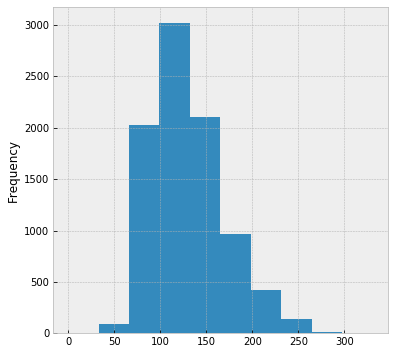

In [717]:
plt.figure(figsize=(6,6))
eldata['2013-01-01':'2014-01-01']['MT_046'].plot(kind="hist", ax=plt.gca())

In [732]:
LIMH, LIML = 400, 0

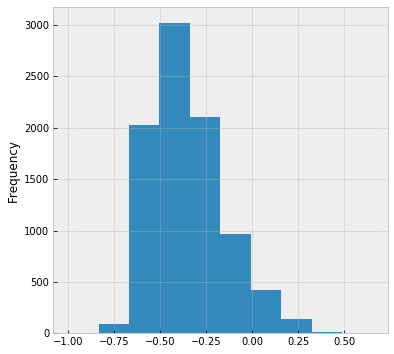

In [733]:
mt_046_train = ((2 * eldata['2013-01-01':'2014-01-01']['MT_046'] - LIML - LIMH) / (LIMH - LIML))
mt_046_train.plot(kind="hist", ax=plt.gca())

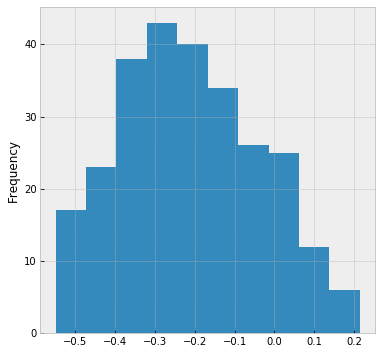

In [734]:
mt_046_test = ((2 * eldata['2014-01-15':'2014-01-25']['MT_046'] - LIML - LIMH) / (LIMH - LIML))
mt_046_test.plot(kind="hist", ax=plt.gca())

In [833]:
# single household
train_data = data['2013-01-01':'2014-01-01'][['MT_046'] + calendar_features]
train_data = train_data / train_data.max()
test_data = data['2014-01-15':'2014-01-25'][['MT_046'] + calendar_features]
test_data = test_data / test_data.max()

In [837]:
# multi households
households = ['MT_004', 'MT_006', 'MT_008', 'MT_021', 'MT_031', 'MT_035', 'MT_037', 'MT_038', 'MT_046', 'MT_050']
train_data = data['2013-01-01':'2014-01-01'][households + calendar_features]
train_data = train_data / train_data.max()
test_data = data['2014-01-15':'2014-01-25'][households + calendar_features]
test_data = test_data / test_data.max()

In [820]:
# small
train_data = data['2013-01-01':'2014-01-01']
train_data = train_data / train_data.max()
test_data = data['2014-01-15':'2014-01-25']
test_data = test_data / test_data.max()

In [768]:
# train_data = data['2013-01-01':'2014-01-01'][calendar_features].join(mt_046_train)
# test_data = data['2014-01-15':'2014-01-25'][calendar_features].join(mt_046_test)

In [786]:
horizon_size = 24
hidden_size = 10
quantiles = [0.5]
dropout = 0.3
layer_size = 2
bidirection = False
lr = 1e-4
batch_size = 1
num_epochs = 100
context_size = 5
covariate_size = train_data[calendar_features].shape[1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [787]:
train_data.shape, test_data.shape

((8784, 373), (264, 373))

In [838]:
dset = MQRNN_dataset(
    train_data[[i for i in train_data.columns if i not in calendar_features]], 
    train_data[calendar_features], 
    horizon_size, len(quantiles))

self.covariate_df.shape[0] : 8784
full_covariate shape: (8760, 1, 24, 3)


In [835]:
net = MQRNN(horizon_size,hidden_size,quantiles,dropout,layer_size,by_direction,lr,batch_size,num_epochs,context_size,covariate_size,device)

device is: cuda:0


In [851]:
net.lr = 1e-5

In [ ]:
net.train(dset)

epoch_num:0
epoch_num 1, current loss is: 0.018254663166450642
epoch_num:1
epoch_num 2, current loss is: 0.01820840387523386
epoch_num:2
epoch_num 3, current loss is: 0.01822258425266957
epoch_num:3
epoch_num 4, current loss is: 0.01817646508528943
epoch_num:4
epoch_num 5, current loss is: 0.018165889838696252
epoch_num:5
epoch_num 6, current loss is: 0.018179388486570903
epoch_num:6
epoch_num 7, current loss is: 0.018168423835061516
epoch_num:7
epoch_num 8, current loss is: 0.018169262874918744
epoch_num:8
epoch_num 9, current loss is: 0.01821515041217775
epoch_num:9
epoch_num 10, current loss is: 0.018165953629879345
epoch_num:10
epoch_num 11, current loss is: 0.01818043268011162
epoch_num:11
epoch_num 12, current loss is: 0.018172990478639493
epoch_num:12
epoch_num 13, current loss is: 0.018225846273653524
epoch_num:13
epoch_num 14, current loss is: 0.018160006185886764
epoch_num:14
epoch_num 15, current loss is: 0.018195175875388443
epoch_num:15
epoch_num 16, current loss is: 0.018

next_covariate_tensor: torch.Size([1, 72])
input_target_covariate_tensor shape: torch.Size([8784, 1, 4])
hidden shape: torch.Size([1, 1, 10])
next_covariate_tensor: torch.Size([1, 1, 72])


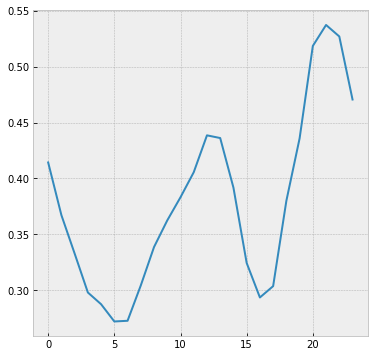

In [802]:
(pd.Series((net.predict(
    train_data[['MT_046']],
    train_data[calendar_features],
    test_data[calendar_features].iloc[24:48],'MT_046'))[0.5])).plot()

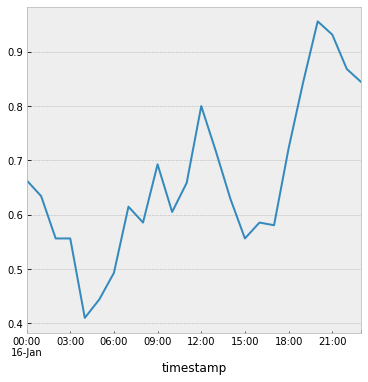

In [803]:
(test_data['MT_046'].iloc[24:48]).plot()

next_covariate_tensor: torch.Size([1, 72])
input_target_covariate_tensor shape: torch.Size([8784, 1, 4])
hidden shape: torch.Size([1, 1, 10])
next_covariate_tensor: torch.Size([1, 1, 72])


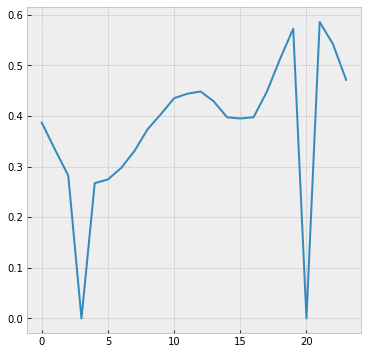

In [849]:
(pd.Series((net.predict(
    train_data[['MT_037']],
    train_data[calendar_features],
    test_data[calendar_features].iloc[24:48],'MT_037'))[0.5])).plot()

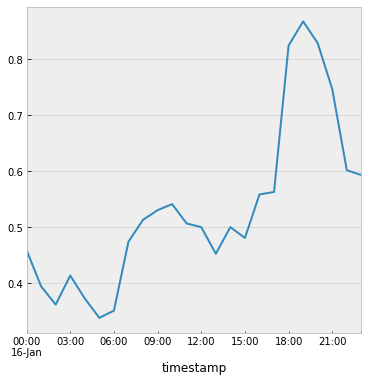

In [850]:
(test_data['MT_037'].iloc[24:48]).plot()

In [ ]:
'MT_004', 'MT_006', 'MT_008', 'MT_021', 'MT_031', 'MT_035', 'MT_037', 'MT_038', 'MT_046', 'MT_050'

In [832]:
eldata['2013':].iloc[:, 40:50]

,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050
timestamp,,,,,,,,,,
2013-01-01 00:00:00,0.000000,46.378653,1198.863636,52.650177,53.299492,191.943128,35.354873,16.352695,970.108696,173.487544
2013-01-01 01:00:00,0.000000,41.296061,1130.681818,45.759717,49.492386,187.203791,34.163136,16.352695,1016.304348,171.708185
2013-01-01 02:00:00,0.000000,34.942821,1022.727273,42.932862,46.954315,163.507109,28.601695,14.521193,918.478261,175.266904
2013-01-01 03:00:00,0.000000,37.801779,886.363636,34.805654,53.722504,139.810427,24.894068,13.474621,790.760870,143.238434
2013-01-01 04:00:00,0.000000,36.531131,875.000000,31.625442,38.917090,143.364929,21.848517,12.820513,684.782609,131.672598
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,159.659091,82.274460,1767.045455,68.374558,98.138748,210.900474,45.683263,17.922554,1461.956522,222.419929
2014-12-31 21:00:00,151.420455,72.426938,1534.090909,64.840989,79.103215,186.018957,39.989407,18.707483,1309.782609,214.412811
2014-12-31 22:00:00,150.568182,66.709022,1352.272727,72.084806,77.411168,188.388626,35.222458,15.960230,1252.717391,219.750890
